# Скачивание датасета из Kaggle

Устанавливаем библиотеку Kaggle, если она еще не установлена.

In [1]:
! pip install -q kaggle

Загружает файл конфигурации Kaggle (kaggle.json) через интерфейс Google Colab.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iesdaikahrad","key":"b835bfd3a5556d249ab6cd3b486a6ce6"}'}

Создает директорию ~/.kaggle/ (скрытая директория для хранения конфигурации Kaggle).

In [3]:
! mkdir ~/.kaggle

Копирует загруженный файл kaggle.json в директорию ~/.kaggle/ для аутентификации.

In [4]:
! cp kaggle.json ~/.kaggle/

Настраивает права доступа к файлу kaggle.json для обеспечения безопасности.

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

Выводит список доступных датасетов на Kaggle.

In [6]:
! kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           9524        364  1.0              
juhibhojani/house-price                                     House Price                                        7MB  2023-08-02 16:51:21           1151         42  0.9411765        
arnavsmayan/netflix-userbase-dataset                        Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41          11033        196  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset    Cardiovascular Diseases Risk Predic

Скачивает датасет из соревнования "dogs-vs-cats-redux-kernels-edition".

In [7]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

100% 812M/814M [00:11<00:00, 78.3MB/s]
100% 814M/814M [00:11<00:00, 74.6MB/s]


Распаковывает скачанные архивы с данными, используя команды

In [ ]:
! unzip dogs-vs-cats-redux-kernels-edition

In [ ]:
! unzip train

In [ ]:
! unzip test

# Предварительная обработка

Импортируем необходимые библиотеки и модули для предварительной обработки данных.

In [1]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
import re

Определяем директории с данными для обучения и тестирования.

In [2]:
DIRECTORY_TRAIN = "/content/train"
DIRECTORY_TEST = "/content/test"

Задаем размер изображений после изменения размера. Определяем регулярное выражение для разделения имени файла на части. Создаем пустые списки data_train и data_test для хранения данных обучения и тестирования. Инициализируем счетчики i и j для подсчета котов и собак в обучающем наборе.

In [ ]:
IMG_SIZE = 100
PATTERN = r'\W+'

data_train = []
data_test = []

i = 0
j = 0

Перебираем файлы в директории обучающего набора, загружает изображения, изменяет их размер и добавляет данные в список data_train.

In [3]:
for img in os.listdir(DIRECTORY_TRAIN):
  if i > 5000 or j > 5000:
    continue
  label = 0 if re.split(PATTERN, img)[0] == 'cat' else 1
  img_path = os.path.join(DIRECTORY_TRAIN, img)
  img_arr = cv2.imread(img_path)
  img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
  data_train.append([img_arr, label])
  if label == 0:
    i += 1
  else:
    j += 1


Смотрим сколько вышло данных для обучения

In [4]:
len(data_train)

9920

Перемешиваем данные обучения.

In [5]:
random.shuffle(data_train)

Инициализируем пустые списки X и y для хранения признаков и меток классов. Разделяем данные обучения на признаки X и метки классов y.

In [6]:
X = []
y = []

for features, labels in data_train:
  X.append(features)
  y.append(labels)

Преобразуем списки X и y в массивы NumPy.

In [7]:
X = np.array(X)
y = np.array(y)

Выводим количество образцов и меток классов.

In [8]:
len(X), len(y)

(9920, 9920)

# Обучение

Нормализуем данные путем деления на 255 для масштабирования значений пикселей.

In [9]:
X = X/255

Выводим размерность массива данных X.

In [10]:
X.shape

(9920, 100, 100, 3)

Импортируем необходимые слои и модули из библиотеки Keras.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import keras
from keras.utils.np_utils import to_categorical

Преобразуем метки классов в бинарное представление (one-hot encoding).

In [12]:
y = to_categorical(y)

Создаем последовательную модель нейронной сети. Добавляем 4 сверточных слоя, за которыми следуют слои пулинга для извлечения признаков. Добавляем плоский слой для выравнивания выходных данных сверточного слоя. Добавляем полносвязный слой с 512 нейронами и функцией активации ReLU. Добавляем слой нормализации данных для обеспечения стабильного и быстрого обучения. И добавлвем последний(выходной) слой 2 нейронами и функцией активации sigmoid для бинарной классификации.

In [13]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(BatchNormalization())

model.add(Dense(2, activation='sigmoid'))

Компилируем модель с оптимизатором, функцией потерь и метрикой.

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Выводим структуру модели.

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

Обучаем модель на данных на 10 эпохах и разделением на тренировочную и валидационную выборки, в соотношении 70% и 30% соответственно.

In [17]:
history = model.fit(X, y, epochs=10, validation_split=0.3)

Epoch 1/10
217/217 [==============================] - 290s 1s/step - loss: 0.6431 - accuracy: 0.6446 - val_loss: 0.6828 - val_accuracy: 0.5071
Epoch 2/10
217/217 [==============================] - 273s 1s/step - loss: 0.5851 - accuracy: 0.6869 - val_loss: 0.6294 - val_accuracy: 0.5817
Epoch 3/10
217/217 [==============================] - 284s 1s/step - loss: 0.5270 - accuracy: 0.7343 - val_loss: 0.7222 - val_accuracy: 0.5968
Epoch 4/10
217/217 [==============================] - 289s 1s/step - loss: 0.4900 - accuracy: 0.7628 - val_loss: 0.5464 - val_accuracy: 0.7288
Epoch 5/10
217/217 [==============================] - 284s 1s/step - loss: 0.4581 - accuracy: 0.7843 - val_loss: 0.8379 - val_accuracy: 0.6126
Epoch 6/10
217/217 [==============================] - 275s 1s/step - loss: 0.4213 - accuracy: 0.8050 - val_loss: 0.4883 - val_accuracy: 0.7752
Epoch 7/10
217/217 [==============================] - 285s 1s/step - loss: 0.3982 - accuracy: 0.8204 - val_loss: 0.4708 - val_accuracy: 0.7799

Визуализируем структуру модели.

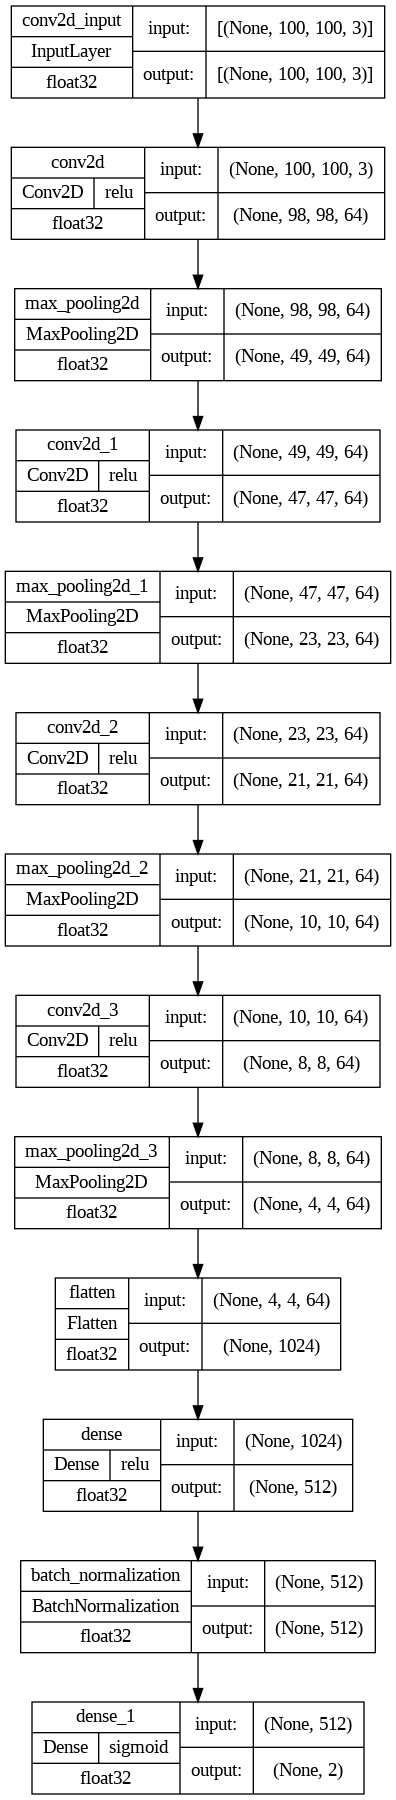

In [18]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

Импортируем библиотеку pandas для анализа и визуализации данных. Создаем DataFrame для анализа и визуализации истории обучения. Визуализируем графики изменения функции потерь и точности на тренировочном и валидационном наборах данных.

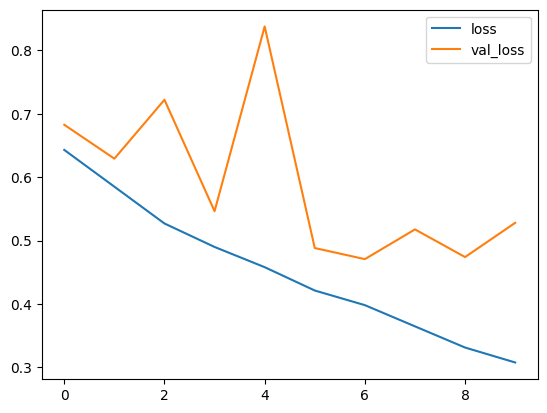

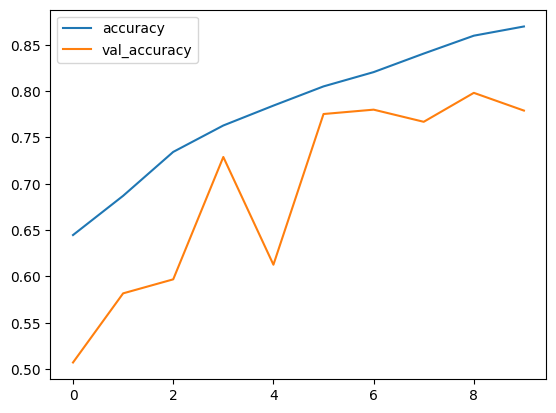

In [19]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

# Проверка модели на тестовых данных

Загружаем изображение, изменяем его размер и добавляет в список данных тестирования data_test.

In [20]:
for img in os.listdir(DIRECTORY_TEST):
  img_path = os.path.join(DIRECTORY_TEST, img)
  img_arr = cv2.imread(img_path)
  img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
  data_test.append([img_arr])

Создаем массив X_test для хранения изображений тестовых данных. Преобразуем изображения в массив NumPy и нормализует данные.

In [21]:
X_test = []
for features in data_test:
  X_test.append(features[0])
X_test = np.array(X_test)
X_test = X_test / 255

Выбираем одно изображение для демонстрации. Расширяем измерение выбранного изображения для соответствия ожиданиям модели. Визуализируем выбранное изображение. Предсказываем класс для выбранного изображения с помощью модели.

1/1 [==============================] - 0s 56ms/step
Dog


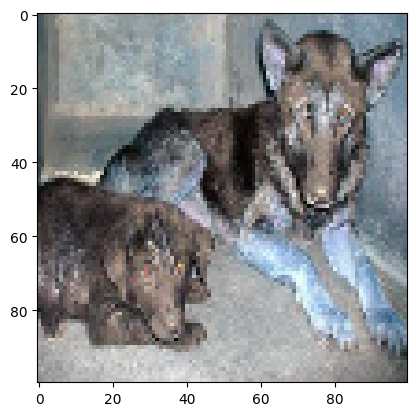

In [34]:
x = X_test[2345]
X_test_1 = np.expand_dims(x, axis=0)
plt.imshow(x)
result = model.predict(X_test_1)
if result[0][0] > 0.5:
  print('Cat')
else:
  print('Dog')

1/1 [==============================] - 0s 109ms/step
Cat


array([[0.72351015, 0.33509704]], dtype=float32)

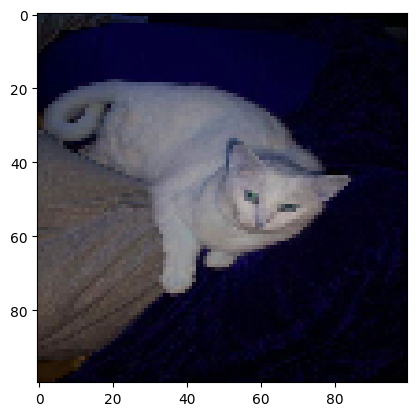

In [33]:
x = X_test[4567]
X_test_1 = np.expand_dims(x, axis=0)
plt.imshow(x)
result = model.predict(X_test_1)
if result[0][0] > 0.5:
  print('Cat')
else:
  print('Dog')
result

# Скачивание содели

Сохраняем содель с расширением h5, тк это формат файлов, используемый для сохранения моделей глубокого обучения, созданных с использованием библиотеки Keras.

In [35]:
model.save('model_accuracy_86.h5')

In [36]:
import tensorflow as tf
from tensorflow import keras

Выгружаем модель и проверяем на работоспособность. 

In [37]:
new_model = tf.keras.models.load_model('model_accuracy_86.h5')

1/1 [==============================] - 0s 75ms/step
Cat


array([[0.9077011 , 0.12630767]], dtype=float32)

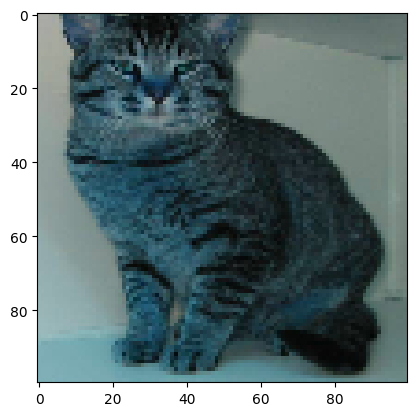

In [39]:
x = X_test[678]
X_test_1 = np.expand_dims(x, axis=0)
plt.imshow(x)
result = new_model.predict(X_test_1)
if result[0][0] > 0.5:
  print('Cat')
else:
  print('Dog')
result